## Explainability (SHAP) on Random Forest

In this part of the project, explains *how* the Random Forest model makes its revenue predictions.

Using SHAP to:
- see which inputs influence predictions the most overall (global explanation)
- show how one important input (budget) affects predicted revenue (dependence plot) and, 
- explain one single prediction (local explanation)




In [1]:
#roy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
 !pip install shap




   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 548.0/548.0 kB 9.2 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 22.8 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ------- -------------------------------- 7.3/38.1 MB 34.9 MB/s eta 0:00:01
   --------------------- ------------------ 20.4/38.1 MB 49.7 MB/s eta 0:00:01
   ------------------------------------ --- 35.1/38.1 MB 57.2 MB/s eta 0:00:01
   ---------------------------------------- 38.1/38.1 MB 49.5 MB/s  0:00:00

   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- -------------------

## Loading the trained Random Forest model and the test dataset

Loading:
- the already-trained Random Forest model (`rf_model.joblib`)
- the test feature set (`X_test.parquet`)

This avoids re-training the model inside the explainability notebook.


In [5]:
#roy

# Loading the tuned model 
import joblib

rf_baseline = joblib.load("rf_model.joblib")




In [ ]:
#roy
import pandas as pd


In [11]:
#roy

# Loading the test set features (same split used in the modelling notebook)
X_test = pd.read_parquet("X_test.parquet")
print("X_test shape:", X_test.shape)

# loading the training features (SHAP might use this as a background sample)
X_train = pd.read_parquet("X_train.parquet")
print("X_train shape:", X_train.shape)



X_test shape: (933, 1746)
X_train shape: (4353, 1746)


In [12]:
#roy
# loading target  to compare predictions vs actual later
y_test_df = pd.read_parquet("y_test.parquet")

# In case y_test is saved as a 1-column dataframe
if y_test_df.shape[1] == 1:
    y_test = y_test_df.iloc[:, 0]
else:
    # if it has a named column, it will pick the first one
    y_test = y_test_df[y_test_df.columns[0]]


In [13]:
#roy
#content check
print("y_test shape:", y_test.shape)

y_test shape: (933,)


### Using the same split as in the modelling notebook

For fairness and consistency, SHAP is computed on a held-out set.


In [14]:
#roy
# Sample size for SHAP 
n = 500

if X_test.shape[0] > n:
    X_shap = X_test.sample(n=n, random_state=42)
else:
    X_shap = X_test.copy()

print("X_shap shape:", X_shap.shape)


X_shap shape: (500, 1746)


## Computing the SHAP values for the Random Forest

SHAP values show how each feature pushes the model’s prediction:
- positive SHAP value means that predicted revenue is pushed up.
- negative SHAP value means that predicted revenue is pushed down.

Because Random Forest is a tree-based model, the tree SHAP explainer is used


In [16]:
#roy
# TreeExplainer is suited for tree-based models like Random Forest


import shap

explainer = shap.TreeExplainer(rf_baseline)


c:\Users\sreej\anaconda3\envs\AIforbusiness\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
#roy
# Computing the SHAP values for the sample
shap_values = explainer.shap_values(X_shap)


In [20]:
#roy
import numpy as np

print("SHAP computed.")
print("SHAP array shape:", np.array(shap_values).shape) # content check

SHAP computed.
SHAP array shape: (500, 1746)


## Global explanation: Which factors matter most overall?

This plot ranks the most influential features in the Random Forest predictions.
It helps answer: “What mainly drives predicted revenue across films?”



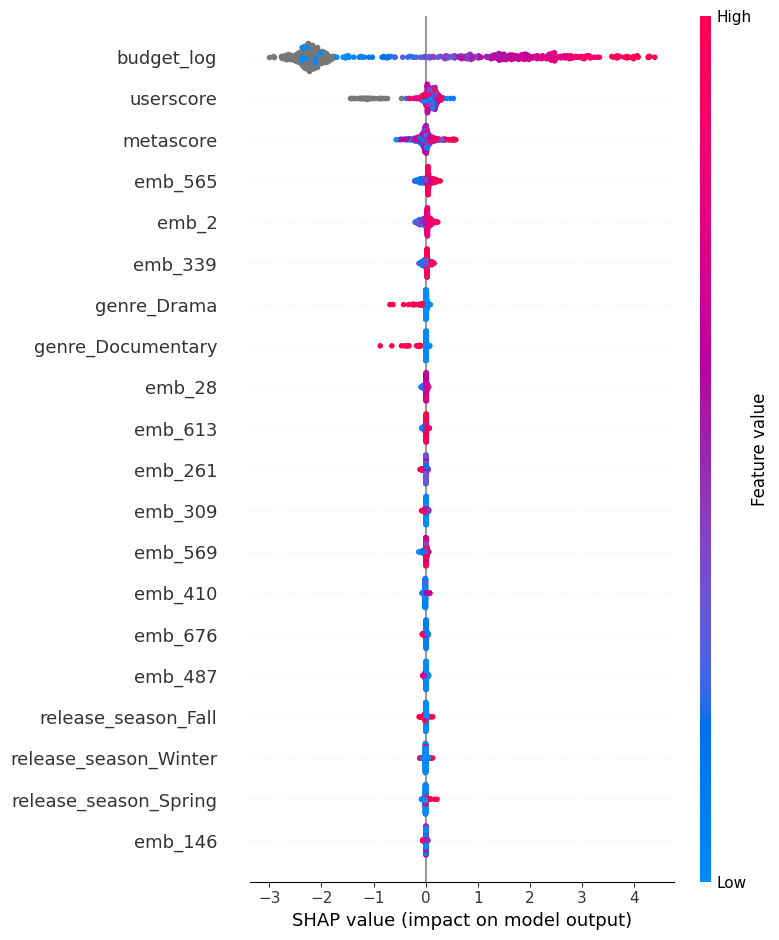

In [21]:
#roy
shap.summary_plot(shap_values, X_shap, show=True)


Figure # Global Feature Influence on Revenue Predictions (SHAP on Random Forest)

This SHAP summary plot shows how different features influence the Random Forest’s revenue predictions across all films. Production budget (log-transformed) is the dominant driver, with higher budgets strongly increasing predicted revenue. User scores, critic scores, and selected expert-review signals provide additional but smaller contributions, while genre and release season have relatively limited overall impact.

## Focusing on business-readable features

Since there are many embedding features (`emb_...`), the SHAP plot can be cluttered.
Here a simplified view that focuses on structured, business-readable inputs
(e.g., budget, scores, season, quarter, genre).

This does not change the model, it only makes the explanation easier to present.


In [18]:
#roy
# Keeping only the non-embedding columns
non_emb_cols = [c for c in X_shap.columns if not c.startswith("emb_")]

In [22]:
#roy
X_shap_structured = X_shap[non_emb_cols].copy()
print("Structured view shape:", X_shap_structured.shape)

Structured view shape: (500, 978)


In [4]:
#roy #error code block for the code block below
import pandas as pd

X_test = pd.read_parquet("X_test.parquet")

import joblib
import shap

rf_baseline = joblib.load("rf_model.joblib")
explainer = shap.TreeExplainer(rf_baseline)



c:\Users\sreej\anaconda3\envs\AIforbusiness\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


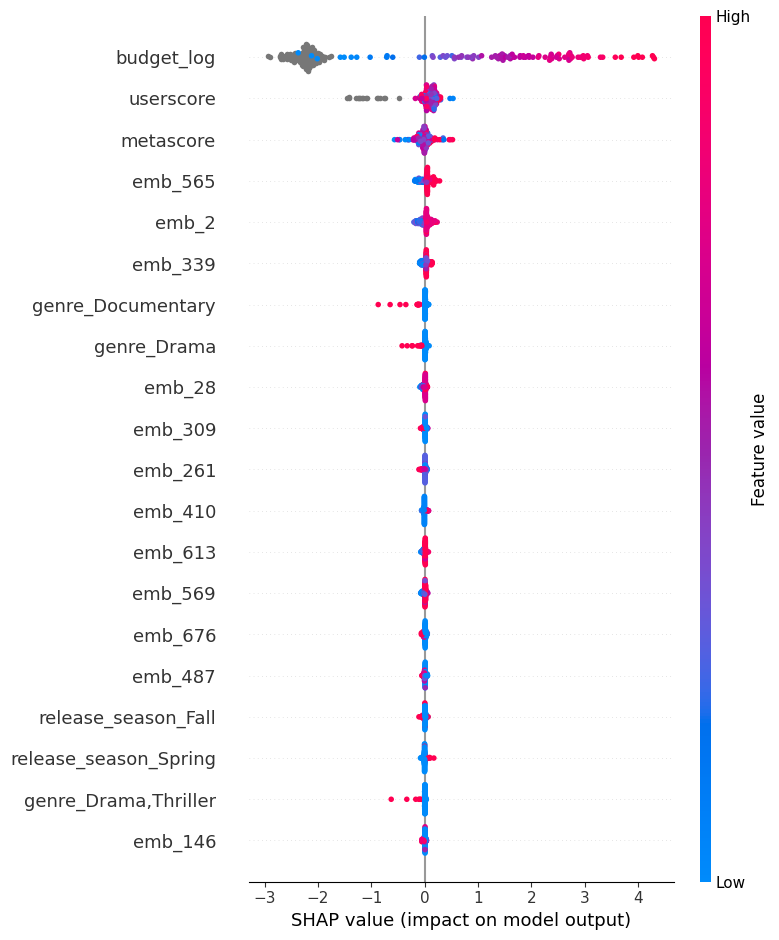

In [5]:
#roy
# Recomputing SHAP on the structured-only view (which leads to faster and cleaner plots)
# sampled to avoid a kernel crash
X_shap_sample = X_test.sample(200, random_state=42)


shap_values_structured = explainer.shap_values(
    X_shap_sample,
    check_additivity=False
)

shap.summary_plot(shap_values_structured, X_shap_sample, show=True)


Figure # Key Revenue Drivers Identified by SHAP (Random Forest Model)

This SHAP summary plot highlights the features that most influence the Random Forest’s revenue predictions. Production budget remains the strongest driver, while user and critic scores contribute additional explanatory power. Genre indicators and expert-review embedding features have smaller, more nuanced effects, suggesting they refine predictions rather than dominate them.

## An example relationship: How does budget affect predicted revenue?

This dependence plot shows how `budget_log` influences predicted revenue.
It gives an interpretation of how spending level relates to expected outcomes.


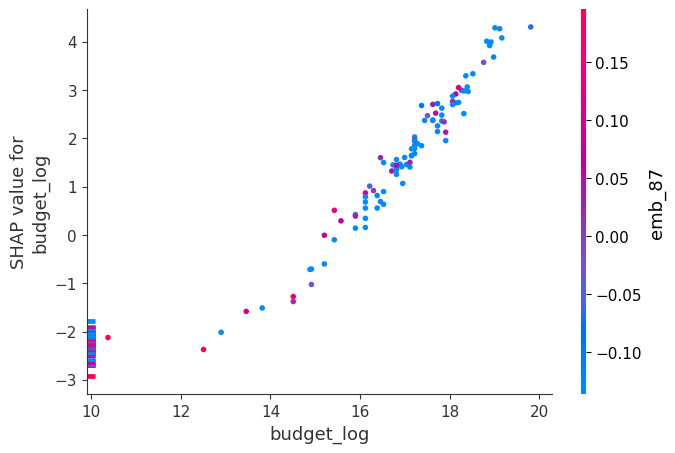

In [ ]:
#roy

shap.dependence_plot(
    "budget_log",
    shap_values_structured,
    X_shap_sample,
    show=True
)
#plot to show dependence



Figure # Effect of Production Budget on Predicted Revenue (SHAP Dependence Plot)

This dependence plot shows a clear positive relationship between production budget (log-transformed) and predicted revenue. As budget increases, its SHAP value rises steadily, indicating that higher budgets consistently push revenue predictions upward. The relatively smooth upward pattern suggests that budget has a strong and stable influence across films, with limited interaction effects.

## Local explanation: Why did the model predict this value for one film?

Here one film is picked from the test set and which features pushed its prediction up or down are shown.



In [11]:
#roy
# Picking one film from the SHAP sample
row_id = X_shap_sample.index[0]
x_one = X_shap_sample.loc[[row_id]]


# Modeling the prediction for this film (log revenue)
pred_log = rf_baseline.predict(x_one)[0]

print("Predicted log revenue:", pred_log)

import pandas as pd

y_test = pd.read_parquet("y_test.parquet")

# comparing with actual target value
if row_id in y_test.index:
    print("Actual log revenue:", y_test.loc[row_id])


Predicted log revenue: 19.429533640620267
Actual log revenue: target    19.11206
Name: 8770, dtype: float64


In [12]:
#roy
# Compute SHAP for this single example
shap_one = explainer.shap_values(x_one)


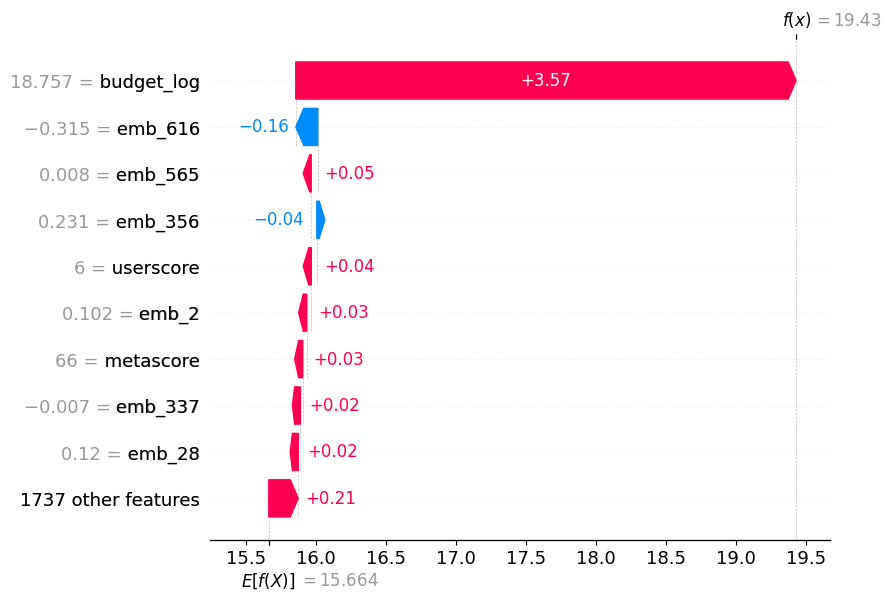

In [13]:
#roy
# Waterfall plot 
shap.plots.waterfall(
    shap.Explanation(
        values=shap_one[0],
        base_values=explainer.expected_value,
        data=x_one.iloc[0],
        feature_names=x_one.columns
    )
)

Figure # Local Explanation of a Single Revenue Prediction (SHAP Waterfall Plot)

This waterfall plot explains how the Random Forest arrived at the predicted revenue for a single film. The production budget is the main factor pushing the prediction well above the model’s baseline expectation, while review-based signals and score-related features provide smaller positive and negative adjustments. Together, these contributions lead to the final predicted log revenue shown on the right.

## SHAP Conclusion


The SHAP analysis provides clear insight into how the Random Forest model forms its revenue predictions.

Across the global SHAP summary plots, **production budget (log-transformed)** consistently emerges as the most influential factor. Higher budgets strongly push predicted revenue upward, while lower budgets contribute negatively, confirming that budget is the dominant commercial driver in box-office performance. This effect is substantially stronger than any other individual variable, highlighting its central role in the model’s decision-making.

Beyond budget, **user scores and critic scores (metascore)** show a meaningful but secondary influence. Higher audience and critic evaluations tend to slightly increase predicted revenue, suggesting that early reception and perceived quality contribute additional explanatory power beyond financial inputs. These effects are visible but clearly smaller compared to budget, indicating that reputation enhances rather than replaces financial scale.

Several **expert-review embedding features** also appear among the top contributors. While individual embeddings are not directly interpretable on their own, their presence indicates that information extracted from pre-release expert reviews adds nuance to the predictions. This suggests that qualitative sentiment and language patterns provide complementary signals that refine revenue expectations.

Genre and release-season variables have relatively modest effects in comparison. Their limited SHAP impact implies that, while timing and genre matter, they do not override the influence of budget and early reception signals in this model.

The dependence plot for `budget_log` further reinforces these findings by showing a clear, mostly monotonic relationship: as production budget increases, the predicted revenue impact rises sharply. This pattern supports the model’s internal consistency and aligns with industry intuition.

Finally, the local (single-film) SHAP explanation demonstrates how the model combines multiple inputs to reach a specific prediction. In this example, a high production budget is the primary driver pushing the predicted revenue above the model’s baseline expectation, while review-based and score-related features provide smaller positive or negative adjustments. The close alignment between predicted and actual log revenue for this case further supports the model’s credibility.

Overall, the SHAP results increase transparency by showing that the Random Forest model relies on **economically intuitive drivers**, while also leveraging expert-review information to fine-tune predictions. This strengthens confidence in the model’s use as a decision-support tool rather than a black-box forecasting system.

